In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import gc
import pickle
import os
import sklearn
from sklearn.preprocessing import LabelEncoder
import xgboost
from xgboost import XGBRegressor

%matplotlib inline

!python -V

print('pandas={}'.format(pd.__version__))
print('numpy={}'.format(np.__version__))
print('matplotlib={}'.format(matplotlib.__version__))
print('sklearn={}'.format(sklearn.__version__))
print('xgboost={}'.format(xgboost.__version__))

Python 3.6.7
pandas=0.24.2
numpy=1.16.3
matplotlib=3.0.3
sklearn=0.21.1
xgboost=0.90


# ->Data

In [0]:
#in this notebook sales/matrix/matrix_mod is refered as train set

item_cat_raw=pd.read_csv('../input/item_categories.csv')
items_raw=pd.read_csv('../input/items.csv')
sales_raw=pd.read_csv('../input/sales_train.csv')
shops_raw=pd.read_csv('../input/shops.csv')
test_raw=pd.read_csv('../input/test.csv')

item_cat=item_cat_raw.copy()
items=items_raw.copy()
sales=sales_raw.copy() #train set
shops=shops_raw.copy()
test=test_raw.copy()

# ->EDA

## Outlier Detection

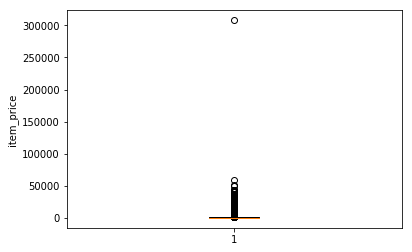

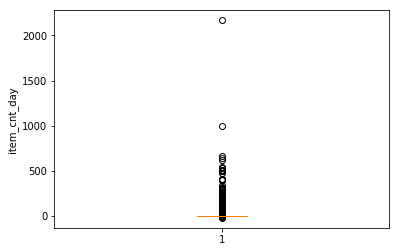

In [0]:
plt.boxplot(sales['item_price'])
plt.ylabel('item_price')
plt.show();
plt.boxplot(sales['item_cnt_day'])
plt.ylabel('item_cnt_day')
plt.show();

## Monthly Trend of Target Variable

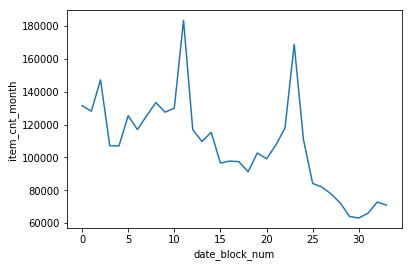

In [0]:
gb=sales[['date_block_num','item_cnt_day']].groupby('date_block_num').agg('sum')
gb.columns=['item_cnt_month']
plt.xlabel('date_block_num')
plt.ylabel('item_cnt_month')
plt.plot(gb.index,gb['item_cnt_month']);

# ->Feature generation and Preprocessing

## Data Cleaning

In [0]:
#removing outliers

sales=sales[(sales['item_price']<300000)&(sales['item_cnt_day']<2000)]
sales.shape

(2935847, 6)

In [0]:
#one of the row in the train data has negative item_price,which is impossible in real life!

sales[sales['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [0]:
#replacing negative item_price with the median

median=sales[(sales['date_block_num']==4)&(sales['shop_id']==32)&(sales['item_id']==2973)&(sales['item_price']>0)]['item_price'].median()
sales.loc[sales['item_price']<0,'item_price']=median
sales[(sales['date_block_num']==4)&(sales['shop_id']==32)&(sales['item_id']==2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484683,15.05.2013,4,32,2973,1874.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


## Generating features from shops,items and item_categories

In [0]:
#We will be using 'xgboost' with trees for the prediction. 
#Trees work quite well with categorical features, 
#so here we create several categorical features with label encoder

In [0]:
#'shop_id's 0 and 1 are the same as 57 and 58 respectively. 
#The only difference is the Russian word 'фран' attached to both shops 0 and 1. 
#Shops 10 and 11 have the exact same name excpet the last character ('?' vs '2'). 
#These duplicates should be removed!

print(shops[shops['shop_id'].isin([0,57,1,58,10,11])])
sales.loc[sales['shop_id']==0,'shop_id']=57
test.loc[test['shop_id']==0,'shop_id']=57

sales.loc[sales['shop_id']==1,'shop_id']=58
test.loc[test['shop_id']==1,'shop_id']=58

sales.loc[sales['shop_id']==10,'shop_id']=11
test.loc[test['shop_id']==10,'shop_id']=11

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
10     Жуковский ул. Чкалова 39м?       10
11     Жуковский ул. Чкалова 39м²       11
57        Якутск Орджоникидзе, 56       57
58        Якутск ТЦ "Центральный"       58


In [0]:
#Each shop_name starts with the city name.This can be a useful feature. 

shops['city']=shops['shop_name'].apply(lambda x:x.split()[0].strip())
le=LabelEncoder()
shops['city_encoded']=le.fit_transform(shops['city'])
shops.drop(columns=['shop_name','city'],inplace=True)
shops.head()

,shop_id,city_encoded
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


In [0]:
#Each category contains type and subtype in its name
#main category before the hyphen and sub-catagory after hyphen

item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [0]:
cat = item_cat['item_category_name'].apply(lambda x:x.split('-'))
item_cat['main_cat_encoded']=cat.apply(lambda x:x[0].strip())
item_cat['main_cat_encoded']=le.fit_transform(item_cat['main_cat_encoded'])
item_cat['sub_cat_encoded']=cat.apply(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
item_cat['sub_cat_encoded']=le.fit_transform(item_cat['sub_cat_encoded'])
item_cat.head()

,item_category_name,item_category_id,main_cat_encoded,sub_cat_encoded
0,PC - Гарнитуры/Наушники,0,0,29
1,Аксессуары - PS2,1,1,9
2,Аксессуары - PS3,2,1,10
3,Аксессуары - PS4,3,1,11
4,Аксессуары - PSP,4,1,13


In [0]:
item_cat['sub_cat_encoded'].nunique()

65

## Train/Test distribution and split (validation strategy)

In [0]:
sales_unique_shop_ids=sales['shop_id'].unique()
test_unique_shop_ids=test['shop_id'].unique()
inter=len(set(sales_unique_shop_ids).intersection(set(test_unique_shop_ids)))
print('{} {} {}'.format(len(sales_unique_shop_ids),len(test_unique_shop_ids),inter))

57 42 42


In [0]:
sales_unique_item_ids=sales['item_id'].unique()
test_unique_item_ids=test['item_id'].unique()
inter=len(set(sales_unique_item_ids).intersection(set(test_unique_item_ids)))
print('{} {} {}'.format(len(sales_unique_item_ids),len(test_unique_item_ids),inter))
print('number new item_ids present in test but not in train set is {}'.format(len(test_unique_item_ids)-inter))

21806 5100 4737
number new item_ids present in test but not in train set is 363


In [0]:
print('mean of shop_id')
print('train={}'.format(sales['shop_id'].mean()))
print('test={}'.format(test['shop_id'].mean()))
print('\nmean of shop_id')
print('train={}'.format(sales['item_id'].mean()))
print('test={}'.format(test['item_id'].mean()))

mean of shop_id
train=33.31064561606923
test=31.666666666666668

mean of shop_id
train=10197.228063655906
test=11019.39862745098


In [0]:
#We can see that test set contains 363 new items not present in train set
#Also distribution(ie mean) of shop_id and item_id is different in train and test set
#so we need to make distribution of train similar to test set by adding new 
#items/shop pairs not present in the train set for every month
#This can be achieved by creating cartisian product of unique shop_id and item_id in every month

In [0]:
base_cols=['shop_id','item_id','date_block_num']
matrix=[]
for block in sales['date_block_num'].unique():
  
  matrix.append(list(product(*[sales[sales['date_block_num']==block]['shop_id'].unique(),
                          sales[sales['date_block_num']==block]['item_id'].unique(),
                         [block]])))
matrix=pd.DataFrame(np.vstack(matrix),columns=base_cols)

In [0]:
print('mean of shop_id')
print('train={}'.format(sales['shop_id'].mean()))
print('test={}'.format(test['shop_id'].mean()))
print('\nmean of shop_id')
print('train={}'.format(sales['item_id'].mean()))
print('test={}'.format(test['item_id'].mean()))

mean of shop_id
train=33.31064561606923
test=31.666666666666668

mean of shop_id
train=10197.228063655906
test=11019.39862745098


In [0]:
#Now we have similar distribution in train and test set than before

In [0]:
matrix.shape

(10913804, 3)

## Creating monthly target feature

In [0]:
gb=sales[base_cols+['item_cnt_day']].groupby(base_cols).sum()
gb.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
gb.reset_index(inplace=True)
gb.shape

(1609123, 4)

In [0]:
print('min={}, max={}'.format(gb['item_cnt_month'].min(),gb['item_cnt_month'].max()))
gb.head()

min=-22.0, max=1644.0


,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0


In [0]:
#clipping the target feature in the range (0,20)

matrix_mod=pd.merge(matrix,gb,on=base_cols,how='left').fillna(0)
matrix_mod['item_cnt_month']=matrix_mod['item_cnt_month'].clip(0,20)
print(matrix_mod.shape)
print('min={}, max={}'.format(matrix_mod['item_cnt_month'].min(),matrix_mod['item_cnt_month'].max()))

(10913804, 4)
min=0.0, max=20.0


In [0]:
matrix_mod.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
matrix_mod.head()

,shop_id,item_id,date_block_num,item_cnt_month
114910,2,19,0,0.0
117150,2,27,0,1.0
120623,2,28,0,0.0
118316,2,29,0,0.0
114602,2,32,0,0.0


In [0]:
test['date_block_num']=34
test['item_cnt_month']=0
matrix_mod=matrix_mod.append(test.drop(columns=['ID']),ignore_index=True)
print(matrix_mod.shape)
matrix_mod.tail()

(11128004, 4)


,shop_id,item_id,date_block_num,item_cnt_month
11127999,45,18454,34,0.0
11128000,45,16188,34,0.0
11128001,45,15757,34,0.0
11128002,45,19648,34,0.0
11128003,45,969,34,0.0


## Merging shop/item catagories features

In [0]:
matrix_mod=pd.merge(matrix_mod,shops,on=['shop_id'],how='left')
matrix_mod=pd.merge(matrix_mod,items.drop(columns=['item_name']),how='left')
matrix_mod=pd.merge(matrix_mod,item_cat.drop(columns=['item_category_name']),how='left')
matrix_mod.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_encoded,item_category_id,main_cat_encoded,sub_cat_encoded
0,2,19,0,0.0,1,40,11,4
1,2,27,0,1.0,1,19,5,10
2,2,28,0,0.0,1,30,8,55
3,2,29,0,0.0,1,23,5,16
4,2,32,0,0.0,1,40,11,4


## Generating Advanced features (lag and mean encodings)

In [0]:
#This function is used to downcast variable types in order to save memory

def downcast(df):
  for col in df.columns:
    if df[col].dtype=='int64':
      df[col]=df[col].astype('int32')
    elif df[col].dtype=='float64':
      df[col]=df[col].astype('float32')
  return df

In [0]:
matrix_mod=downcast(matrix_mod)

In [0]:
#This function is used to generate lag features

def generate_lag(train, months, lag_column):
    for month in months:
        # Speed up by grabbing only the useful bits
        train_shift = train[['date_block_num', 'shop_id', 'item_id', lag_column]].copy()
        train_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column+'_lag_'+ str(month)]
        train_shift['date_block_num'] += month
        train = pd.merge(train, train_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return train

In [0]:
#target lag feature

matrix_mod=generate_lag(matrix_mod,[1,2,3,4,5,6,12],'item_cnt_month')
matrix_mod.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_encoded,item_category_id,main_cat_encoded,sub_cat_encoded,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_12
0,2,19,0,0.0,1,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,27,0,1.0,1,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,28,0,0.0,1,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,29,0,0.0,1,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,32,0,0.0,1,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#item target mean encode and lag

gb=matrix_mod.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean().rename('item_month_mean').reset_index()
matrix_mod=pd.merge(matrix_mod,gb,on=['date_block_num', 'item_id'],how='left')
matrix_mod=generate_lag(matrix_mod,[1,2,3,6,12],'item_month_mean')
matrix_mod.drop(['item_month_mean'],axis=1,inplace=True)

In [0]:
#shop target mean encode and lag
gb=matrix_mod.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].mean().rename('shop_month_mean').reset_index()
matrix_mod=pd.merge(matrix_mod,gb,on=['date_block_num', 'shop_id'],how='left')
matrix_mod=generate_lag(matrix_mod,[1,2,3,6,12],'shop_month_mean')
matrix_mod.drop(['shop_month_mean'],axis=1,inplace=True)

In [0]:
#shop item category target mean encode and lag

gb=matrix_mod.groupby(['date_block_num', 'shop_id','item_category_id'])['item_cnt_month'].mean().rename('shop_cat_month_mean').reset_index()
matrix_mod=pd.merge(matrix_mod,gb,on=['date_block_num', 'shop_id','item_category_id'],how='left')
matrix_mod=generate_lag(matrix_mod,[1,2],'shop_cat_month_mean')
matrix_mod.drop(['shop_cat_month_mean'],axis=1,inplace=True)

In [0]:
#main categories target mean encode and lag

gb=matrix_mod.groupby(['date_block_num', 'main_cat_encoded'])['item_cnt_month'].mean().rename('main_cat_month_mean').reset_index()
matrix_mod=pd.merge(matrix_mod,gb,on=['date_block_num', 'main_cat_encoded'],how='left')
matrix_mod=generate_lag(matrix_mod,[1],'main_cat_month_mean')
matrix_mod.drop(['main_cat_month_mean'],axis=1,inplace=True)

In [0]:
#sub categories target mean encode and lag

gb=matrix_mod.groupby(['date_block_num', 'sub_cat_encoded'])['item_cnt_month'].mean().rename('sub_cat_month_mean').reset_index()
matrix_mod=pd.merge(matrix_mod,gb,on=['date_block_num', 'sub_cat_encoded'],how='left')
matrix_mod=generate_lag(matrix_mod,[1],'sub_cat_month_mean')
matrix_mod.drop(['sub_cat_month_mean'],axis=1,inplace=True)

In [0]:
matrix_mod.tail()

,shop_id,item_id,date_block_num,item_cnt_month,city_encoded,item_category_id,main_cat_encoded,sub_cat_encoded,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_12,shop_month_mean_lag_1,shop_month_mean_lag_2,shop_month_mean_lag_3,shop_month_mean_lag_6,shop_month_mean_lag_12,shop_cat_month_mean_lag_1,shop_cat_month_mean_lag_2,main_cat_month_mean_lag_1,sub_cat_month_mean_lag_1
11127999,45,18454,34,0.0,21,55,13,2,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.045455,0.023256,0.071429,0.590909,NaN,0.126732,0.12881,0.138998,0.137611,NaN,0.126866,0.074534,0.147004,0.196845
11128000,45,16188,34,0.0,21,64,14,42,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.022727,0.069767,NaN,NaN,NaN,0.126732,0.12881,NaN,NaN,NaN,0.094488,0.117117,0.237314,0.155870
11128001,45,15757,34,0.0,21,55,13,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113636,0.069767,0.095238,0.250000,0.18,0.126732,0.12881,0.138998,0.137611,0.181272,0.126866,0.074534,0.147004,0.196845
11128002,45,19648,34,0.0,21,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.045455,0.069767,0.166667,0.090909,NaN,0.126732,0.12881,0.138998,0.137611,NaN,0.083756,0.074074,0.224269,0.220812
11128003,45,969,34,0.0,21,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068182,0.116279,0.023810,0.068182,0.12,0.126732,0.12881,0.138998,0.137611,0.181272,0.128205,0.067449,0.224269,0.240948


In [0]:
matrix_mod.shape

(11128004, 29)

In [0]:
matrix_mod.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'city_encoded', 'item_category_id', 'main_cat_encoded',
       'sub_cat_encoded', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_4', 'item_cnt_month_lag_5',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'item_month_mean_lag_1', 'item_month_mean_lag_2',
       'item_month_mean_lag_3', 'item_month_mean_lag_6',
       'item_month_mean_lag_12', 'shop_month_mean_lag_1',
       'shop_month_mean_lag_2', 'shop_month_mean_lag_3',
       'shop_month_mean_lag_6', 'shop_month_mean_lag_12',
       'shop_cat_month_mean_lag_1', 'shop_cat_month_mean_lag_2',
       'main_cat_month_mean_lag_1', 'sub_cat_month_mean_lag_1'],
      dtype='object')

## Final Features

In [0]:
matrix_mod['month'] = matrix_mod['date_block_num'] % 12
matrix_mod=downcast(matrix_mod)

# ->Training

In [0]:
#Here we will train on the rows having 'date_block_num'<33
#we will validate on the validate on the last month of train set i.e. 'date_block_num'=33
#we test on the test set i.e. 'date_block_num'==34
#But we will discard all rows of the first year as data in the first year is less likely to affect the
#target variable in the last month.

In [0]:
matrix_mod=matrix_mod[matrix_mod['date_block_num']>11]
matrix_mod.fillna(0,inplace=True)
matrix_mod=matrix_mod.reset_index(drop=True)

In [0]:
#spliting data into appropriate train,validation and test set

x_train=matrix_mod[matrix_mod.date_block_num < 33].drop(['item_cnt_month'], axis=1).values
y_train=matrix_mod[matrix_mod.date_block_num < 33]['item_cnt_month'].values
x_val=matrix_mod[matrix_mod.date_block_num == 33].drop(['item_cnt_month'], axis=1).values 
y_val=matrix_mod[matrix_mod.date_block_num == 33]['item_cnt_month'].values
x_test=matrix_mod[matrix_mod.date_block_num == 34].drop(['item_cnt_month'], axis = 1).values

In [0]:
#saving train,validation and test data on the drive

pickle.dump(x_train,open('x_train.pkl','wb'))
pickle.dump(y_train,open('y_train.pkl','wb'))
pickle.dump(x_val,open('x_val.pkl','wb'))
pickle.dump(y_val,open('y_val.pkl','wb'))
pickle.dump(x_test,open('x_test.pkl','wb'))

In [0]:
#Here we use xgboost regressor model for the train and prediction

def xgtrain():
    _model = XGBRegressor(n_estimators = 5000,
                            learning_rate = 0.1,
                            max_depth = 10,
                            subsample = 0.5,
                            colsample_bytree = 0.5)
    
    model = _model.fit(x_train,y_train,
                        eval_metric = 'rmse', 
                        eval_set = [(x_train,y_train), (x_val,y_val)], 
                        verbose=True,
                        early_stopping_rounds = 2
                      )
    return model

In [0]:
#loading train,validation data from the disk

x_train=pickle.load(open('x_train.pkl','rb'))
y_train=pickle.load(open('y_train.pkl','rb'))
x_val=pickle.load(open('x_val.pkl','rb'))
y_val=pickle.load(open('y_val.pkl','rb'))

In [0]:
%%time
#training/matrics optimization

model=xgtrain()


#saving trained model to the disk (serialization)

pickle.dump(model,open('model.pkl','wb'))

[0]	validation_0-rmse:1.13676	validation_1-rmse:1.12756
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:1.10935	validation_1-rmse:1.10191


In [9]:
import pandas as pd
import pickle
from xgboost import XGBRegressor

#prediction on test set and creating submission file
#loading model from the disk
model=pickle.load(open('model.pkl','rb'))
#loading test data from the disk
x_test=pickle.load(open('x_test.pkl','rb'))

submission = pd.read_csv('sample_submission.csv')
submission['item_cnt_month'] = predictions
submission.to_csv('xgb_submission.csv', index=False)

[01:25:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
submission.head()

,ID,item_cnt_month
0,0,0.662685
1,1,0.362727
2,2,1.082367
3,3,0.489500
4,4,3.279083


In [0]:
!mkdir

<a href='xgb_submission.csv'>Submission.csv</a>

<a href='model.pkl'>model.pkl</a>

<a href='x_test.pkl'>x_test.pkl</a>

<a href='x_train.pkl'>x_train.pkl</a>

<a href='y_train.pkl'>y_train.pkl</a>

<a href='x_val.pkl'>x_val.pkl</a>

<a href='y_val.pkl'>y_val.pkl</a>